In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Config:
file_id =  None #'<add_you_coco_dataset_dive_link>'  #Eg. '1fdgdgssytsyusrtyshgg' ensure data to be zip
file_id_weigths = None #'<trained_weights any>' #Eg. '1fdgdgsgsjusysetg' : format: model_weights_00_100.pth
file_csv = None #<add csv drive id >
file_train_csv = None
file_test_csv = None

In [ ]:
import gdown
import shutil
from pathlib import Path
from IPython.display import clear_output
Gdrive = False # IF you want to save data of images keep true
folder_path = '/content/drive/MyDrive/' if Gdrive else '/content/'
weights_Dir = Path('/content/drive/MyDrive/Colab_zip/multimodel_effnet/weights')
weights_Dir.mkdir(parents=True, exist_ok=True)

In [ ]:
%%bash
cd /content
cd "$folder_path"  #goto location
git clone https://github.com/omer770/multimodel_effnet.git
cd multimodel_effnet
pip install -r requirements.txt -q
cd weights
wget -q https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth #default weights
cd /content/

Cloning into 'multimodel_effnet'...


In [ ]:
if file_id:
  zip_path = gdown.download(id=file_id)
  !unzip -q {zip_path} -d {folder_path+'multimodel_effnet/data'}
  #!rm zip_path
  file_id = None
if file_csv:
  csv_name = gdown.download(id=file_csv)
  shutil.move(csv_name, folder_path+'multimodel_effnet/data')
  file_csv = None
if file_train_csv:
  train_csv_name = gdown.download(id=file_train_csv)
  shutil.move(train_csv_name, folder_path+'multimodel_effnet/data')
  file_train_csv = None
if file_test_csv:
  test_csv_name = gdown.download(id=file_test_csv)
  shutil.move(test_csv_name, folder_path+'multimodel_effnet/data')
  file_test_csv = None
if file_id_weigths:
  weights_path = gdown.download(id=file_id_weigths)
  try:shutil.move(weights_path, weights_Dir)
  except:print(f"{weights_path} path exits")
clear_output()

In [ ]:
%pwd

'/content'

In [ ]:
%cd {folder_path+'multimodel_effnet'}

/content/multimodel_effnet


In [ ]:
import os
import torch
import torchvision
import pandas as pd
from tqdm.auto import tqdm
from pathlib import Path
import torch.optim as optim
from torchinfo import summary
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.utils import save_image
from torchvision.models import efficientnet_b0,EfficientNet_B0_Weights

In [ ]:
from test_runs import make_predictions,model_test
from multimodel_effnet.Efficientnet.util.train_utils import train
from multimodel_effnet.Efficientnet.model import multimodel_effnet_arc
from multimodel_effnet.Efficientnet.util.dataset import CustomImageDataset,create_balanced_df,WeightedSampler
from multimodel_effnet.Efficientnet.util.metrics_utils import cross_entropy_loss_embedded,accuracy_embedded
from multimodel_effnet.Efficientnet.util.visualize import plot_loss_curves,plot_test_results
from multimodel_effnet.Efficientnet.util.metrics_utils import calculate_ConfusionMatrices
from multimodel_effnet.Efficientnet.util.visualize import plot_confusion_matrices,display_random_images

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
#torch.set_default_device(device)
print("device: ",device)
base_path = Path(folder_path)
csv_path = base_path/'multimodel_effnet'/'data'/ csv_name
train_csv_path = base_path/'multimodel_effnet'/'data'/ train_csv_name
test_csv_path = base_path/'multimodel_effnet'/'data'/ test_csv_name
image_directory = '/content/multimodel_effnet/data/Datasets2'
weights_Dir = Path('/content/drive/MyDrive/Colab_zip/multimodel_effnet/weights')
weights_Dir.mkdir(parents=True, exist_ok=True)
df = pd.read_csv(csv_path)
attribs_m = ['Roof Condition', 'Roof Material','Roof Style','Solar Panel', 'Tree Overhang', 'Swimming Pool']
item_2_label_lst = [
    {'Fair':0, 'Good':1, 'Poor':2,'Damaged':3},
    {'Metal':0, 'Poly':1, 'Shingle':2, 'Tile':3,'Ballasted':4,'Asphalt':5},
    {'Flat':0, 'Gabled':1, 'Hip':2, 'Mixed':3},
    {'No':0,'Yes':1},
    {'Low':0, 'Medium':1,'High':2, 'No':3},
    {'No':0, 'Yes':1,'Screened':2}]
label_2_item_lst = [
    {0: 'Fair', 1: 'Good', 2: 'Poor', 3:'Damaged'},
    {0: 'Metal', 1: 'Poly', 2: 'Shingle', 3: 'Tile', 4: 'Ballasted', 5:'Asphalt'},
    {0: 'Flat', 1: 'Gabled', 2: 'Hip', 3: 'Mixed'},
    {0: 'No', 1:'Yes'},
    {0: 'Low', 1: 'Medium', 2:'High', 3: 'No'},
    {0: 'No', 1: 'Yes', 2:'Screened'}]
#print(df.head())

device:  cuda


In [ ]:
weights = EfficientNet_B0_Weights.DEFAULT # .DEFAULT = best available weights
effnet = efficientnet_b0
model = multimodel_effnet_arc.effnet_multimodel(model_name='b1',effnet=effnet, weights =weights)
# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
for param in model.effnet.parameters():
    param.requires_grad = False

In [ ]:
filePaths = [file for file in weights_Dir.iterdir() if file.name.startswith('me_model_weights')]
try:
  latest_weigths = str(filePaths[-1])
  model.load_state_dict(torch.load(latest_weigths,map_location= device))
  print("choosen weights: ",latest_weigths)
except:
  latest_weigths= None
  print("choosen weights: ",latest_weigths)

choosen weights:  None


In [ ]:
# Augment train data
train_transforms = transforms.Compose([
    transforms.CenterCrop(768),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         #std=[0.229, 0.224, 0.225])
])

# Don't augment test data, only reshape
test_transforms = transforms.Compose([
    transforms.CenterCrop(768),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         #std=[0.229, 0.224, 0.225]),
])

In [ ]:
train_data_custom = CustomImageDataset(annotations_file=train_csv_path,
                                      img_dir=image_directory,
                                      attribs=attribs_m,
                                      item_2_label_lst =item_2_label_lst,
                                      label_2_item_lst=label_2_item_lst,
                                      #device = device,
                                      transform=train_transforms)
sampler_train = WeightedSampler(train_data_custom, weights_strategy='image-level')
test_data_custom = CustomImageDataset(annotations_file=test_csv_path,
                                      img_dir=image_directory,
                                      attribs=attribs_m,
                                      item_2_label_lst =item_2_label_lst,
                                      label_2_item_lst=label_2_item_lst,
                                      #device=device,
                                      transform=test_transforms)
sampler_test = WeightedSampler(test_data_custom, weights_strategy='image-level')

In [ ]:
display_random_images(train_data_custom,n=5,classes = True)

In [ ]:
# Get image and label from custom DataLoader
img_custom, label_custom = next(iter(train_data_custom))

# Batch size will now be 1, try changing the batch_size parameter above and see what happens
print(f"Image shape: {img_custom.shape},{img_custom.device} -> [batch_size, color_channels, height, width],device")
print(f"Label of {attribs_m}: {train_data_custom.decode_labels_onehot(label_custom)},{label_custom}")

Image shape: torch.Size([3, 224, 224]),cpu -> [batch_size, color_channels, height, width],device
Label of ['Roof Condition', 'Roof Material', 'Roof Style', 'Solar Panel', 'Tree Overhang', 'Swimming Pool']: ['Fair', 'Metal', 'Gabled', 'No', 'Low', 'No'],[tensor([1., 0., 0., 0.]), tensor([1., 0., 0., 0., 0., 0.]), tensor([0., 1., 0., 0.]), tensor([1., 0.]), tensor([1., 0., 0., 0.]), tensor([1., 0., 0.])]


In [ ]:
NUM_WORKERS = os.cpu_count()
BATCH_SIZE = 32
train_dataloader = DataLoader(
      train_data_custom,
      batch_size=BATCH_SIZE,
      #shuffle=True,
      num_workers=NUM_WORKERS,
      pin_memory=True,
      sampler=sampler_train,
      generator=torch.Generator(device='cpu')
  )
test_dataloader = DataLoader(
      test_data_custom,
      batch_size=BATCH_SIZE,
      #shuffle=False,
      num_workers=NUM_WORKERS,
      pin_memory=True,
      sampler=sampler_test,
      generator=torch.Generator(device='cpu')
  )

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
summary(model=model,
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                           Input Shape          Output Shape         Param #              Trainable
effnet_multimodel (effnet_multimodel)                             [32, 3, 224, 224]    [32, 4]              --                   Partial
├─EfficientNet (effnet)                                           [32, 3, 224, 224]    [32, 1280]           --                   False
│    └─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    │    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   (928)                False
│    │    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112, 112]   (1,448)              False
│    │    └─Sequential (2)                                        [32, 16, 112, 112]   [32, 24, 56, 56]     (16,714)             False
│    │    └─Sequential (3)                       

In [ ]:
from multimodel_effnet.Efficientnet.util.train_utils import train

In [ ]:
filePaths = [file for file in weights_Dir.iterdir() if file.name.startswith('me_model_weights')]
try:
  latest_weigths = str(filePaths[-1])
  print("choosen weights: ",latest_weigths)
except:
  latest_weigths= None
  print("choosen weights: ",latest_weigths)

choosen weights:  /content/drive/MyDrive/Colab_zip/multimodel_effnet/weights/me_model_weights_00_015.pth


In [ ]:
result = train(model=model,
      train_dataloader=train_dataloader,
      test_dataloader=test_dataloader,
      optimizer=optimizer,
      loss_fn=cross_entropy_loss_embedded,
      acc_fn= accuracy_embedded,
      epochs=20,
      latest_weigths = latest_weigths,
      save_path= weights_Dir,
      save_epoch = 5,
      device=device)

100%|██████████| 10/10 [13:23<00:00, 80.30s/it]

Epoch: 10 | train_loss: 0.7715 | train_acc: 0.6908 | test_loss: 0.6198 | test_acc: 0.7563


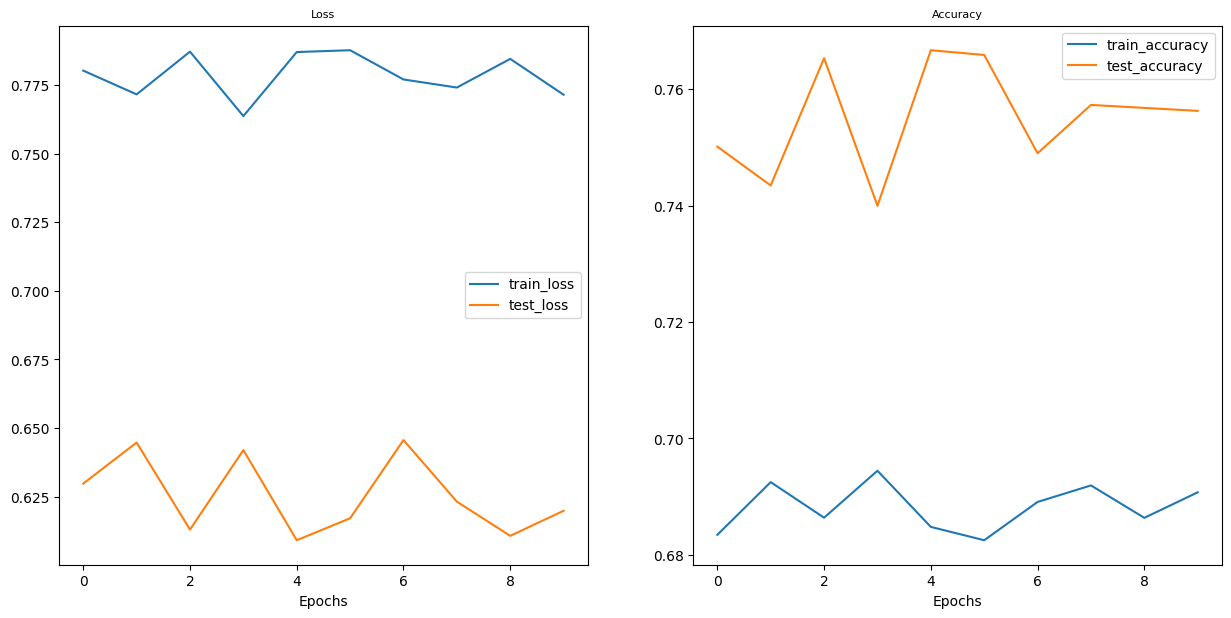

In [ ]:
plot_loss_curves(result)

In [ ]:
#Make Predictions

In [ ]:
import random
import pandas as pd
df_test = pd.read_csv(test_csv_path)
ids = random.sample(range(len(df_test)), k=9)
df_sample = df_test.iloc[ids,:]

In [ ]:
test_sample_custom = CustomImageDataset(annotations_df=df_sample,
                                      img_dir=image_directory,
                                      attribs=attribs_m,
                                      item_2_label_lst =item_2_label_lst,
                                      label_2_item_lst=label_2_item_lst,
                                      #device = device,
                                      transform=test_transforms)

In [ ]:
test_samples = []
test_labels = []
for idx in ids:
  sample, label = test_sample_custom[idx]
  test_samples.append(sample)
  test_labels.append(label)

# View the first test sample shape and label
print(f"Test sample image shape: {test_samples[0].shape}\nTest sample label:{test_data_custom.decode_labels_onehot(test_labels[0])}:{test_labels[0]}")

Test sample image shape: torch.Size([3, 224, 224])
Test sample label:['Fair', 'Poly', 'Mixed', 'No', 'Low', 'Yes']:[tensor([1., 0., 0., 0.]), tensor([0., 1., 0., 0., 0., 0.]), tensor([0., 0., 0., 1.]), tensor([1., 0.]), tensor([1., 0., 0., 0.]), tensor([0., 1., 0.])]


In [ ]:
pred_classes = make_predictions(model=model,data=test_samples)

In [ ]:
plot_test_results(
    test_labels=test_labels,pred_classes=pred_classes,
    test_samples= test_samples,test_data_custom = test_sample_custom
    )

In [ ]:
#Test model:

In [ ]:
filePaths = [file for file in weights_Dir.iterdir() if file.name.startswith('me_model_weights')]
try:
  latest_weigths = str(filePaths[-1])
  #model.load_state_dict(torch.load(latest_weigths,map_location= device))
  print("choosen weights: ",latest_weigths)
except:
  latest_weigths= None
  print("choosen weights: ",latest_weigths)

choosen weights:  /content/drive/MyDrive/Colab_zip/multimodel_effnet/weights/me_model_weights_01_005.pth


In [ ]:
targets_tensors,y_pred_tensors = model_test(test_dataloader, model, device = device)

choosen weights:  None


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Making predictions:   0%|          | 0/32 [00:00<?, ?it/s]

In [ ]:
calculate_ConfusionMatrices(y_pred_tensors,targets_tensors)

Attribute:  'Roof Condition'
Classes:  ['Fair', 'Good', 'Poor', 'Damaged']
Confusion Matrix: 
array([[330,   1,   9,  15],
       [ 67,   0,   2,  10],
       [ 97,   0,   2,   3],
       [438,   9,  11,  12]])
---------------------------------------------------------------------------
Attribute:  'Roof Material'
Classes:  ['Metal', 'Poly', 'Shingle', 'Tile', 'Ballasted', 'Asphalt']
Confusion Matrix: 
array([[225,   0,  58,   8,   0,   1],
       [ 18,  50,  23,   0,   1,   0],
       [ 37,   3, 334,   2,   0,   3],
       [ 20,   0,  20,  48,   0,   0],
       [  2,   3,   0,   0,  64,   0],
       [ 20,   0,  23,   4,   3,  36]])
---------------------------------------------------------------------------
Attribute:  'Roof Style'
Classes:  ['Flat', 'Gabled', 'Hip', 'Mixed']
Confusion Matrix: 
array([[159,  88,   0,   4],
       [ 14, 327,   0,  29],
       [  8,  36,  15,  47],
       [ 24,  71,   0, 184]])
---------------------------------------------------------------------------
At

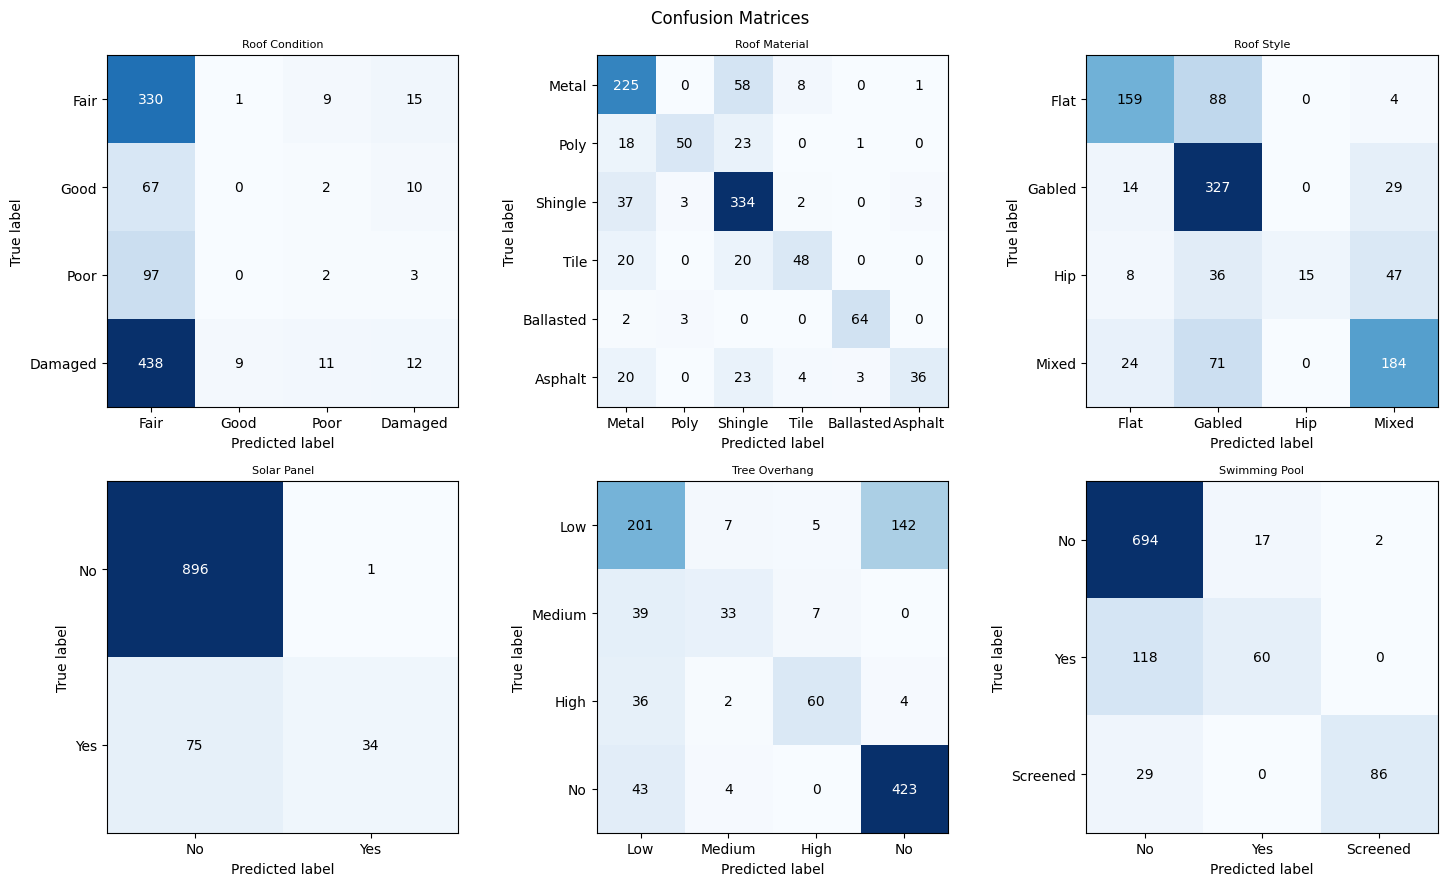

<Figure size 640x480 with 0 Axes>

In [ ]:
plot_confusion_matrices(y_pred_tensors,targets_tensors)